# Detecção de Fraude em Cartões de Crédito — Pipeline *leakage-safe*

- **Split correto**: `train` / `cal` / `test (holdout)`
- **Feature selection** ajustada **somente no treino**
- **Calibração + threshold** escolhidos **somente no CAL**
- **TEST** usado **apenas na avaliação final**


In [0]:
# 1) Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    precision_recall_curve, precision_score, recall_score, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV


from xgboost import XGBClassifier


In [0]:
# 2) Funções utilitárias (métricas e gráficos)

def calcular_ks_statistic(y_true, y_score):
    """KS = max(TPR - FPR) ao longo dos thresholds."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(tpr - fpr))

def get_scores(model, X):
    """Retorna score contínuo preferindo predict_proba[:,1]."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    raise ValueError("Modelo não possui predict_proba nem decision_function.")

def avaliar_modelo(X_train, y_train, X_test, y_test, model, nm_modelo="Modelo"):
    # Scores
    s_tr = get_scores(model, X_train)
    s_te = get_scores(model, X_test)

    auc_tr = roc_auc_score(y_train, s_tr)
    auc_te = roc_auc_score(y_test, s_te)

    gini_tr = 2 * auc_tr - 1
    gini_te = 2 * auc_te - 1

    ks_tr = calcular_ks_statistic(y_train, s_tr)
    ks_te = calcular_ks_statistic(y_test, s_te)

    ap_tr = average_precision_score(y_train, s_tr)
    ap_te = average_precision_score(y_test, s_te)

    out = {
        "modelo": nm_modelo,
        "roc_auc_train": float(auc_tr),
        "roc_auc_test": float(auc_te),
        "gini_train": float(gini_tr),
        "gini_test": float(gini_te),
        "ks_train": float(ks_tr),
        "ks_test": float(ks_te),
        "pr_auc_train": float(ap_tr),
        "pr_auc_test": float(ap_te),
    }
    return out


## 3) Carregar dados



In [0]:
DATA_PATH = "/Volumes/workspace/default/fraudes_em_cartões_de_crédito/creditcard.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 4) Checagens rápidas


In [0]:
print("Shape:", df.shape)
print("Target balance (Class=1):", df["Class"].mean())
df.describe().T.head()


Shape: (284807, 31)
Target balance (Class=1): 0.001727485630620034


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344


In [0]:
def missing_values_table(df):

  metadados = pd.DataFrame({
      'nome_variavel': df.columns,
      'tipos_de_dados': df.dtypes,
      'numero_de_missing': df.isnull().sum(),
      'percentual_de_missing': df.isnull().sum() * 100 / len(df),
      'unknown': df.isin(['unknown']).sum(),
      'percentual_unknown': df.isin(['unknown']).sum() * 100 / len(df),
      'numero_de_unicos': df.nunique(),
  })

  metadados = metadados.sort_values(by='numero_de_missing', ascending=False).round(1)
  metadados = metadados.reset_index(drop=True)

  return metadados

In [0]:
metadados = missing_values_table(df)
metadados.head(31)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,Time,float64,0,0.0,0,0.0,124592
1,V16,float64,0,0.0,0,0.0,275663
2,Amount,float64,0,0.0,0,0.0,32767
3,V28,float64,0,0.0,0,0.0,275663
4,V27,float64,0,0.0,0,0.0,275663
5,V26,float64,0,0.0,0,0.0,275663
6,V25,float64,0,0.0,0,0.0,275663
7,V24,float64,0,0.0,0,0.0,275663
8,V23,float64,0,0.0,0,0.0,275663
9,V22,float64,0,0.0,0,0.0,275663


## 5) Split leakage-safe: Train / Cal / Test (Holdout)
- `TRAIN`= Treino
- `TEST` = holdout final 
- `CAL` = calibração + threshold


In [0]:
TARGET = "Class"

X_all = df.drop(columns=[TARGET])
y_all = df[TARGET].astype(int)

# Holdout final
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)

# Calibração (dentro do treino)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

print("Taxa de fraude (train):", y_train.mean())
print("Taxa de fraude (cal):  ", y_cal.mean())
print("Taxa de fraude (test): ", y_test.mean())


Taxa de fraude (train): 0.0017242352233041362
Taxa de fraude (cal):   0.0017304943194642992
Taxa de fraude (test):  0.0017321489179921118


## 6) Data Prep mínimo (imputação)
O dataset original costuma não ter nulos, mas será mantido o passo para robustez.


In [0]:
imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_cal_imp   = pd.DataFrame(imputer.transform(X_cal), columns=X_cal.columns)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


## 7) Feature Selection 
### 7.1 Filtro de correlação


In [0]:
def correlation_filter(X_df: pd.DataFrame, threshold: float = 0.85):
    corr = X_df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return X_df.drop(columns=to_drop), to_drop

X_corr, dropped_corr = correlation_filter(X_train_imp, threshold=0.85)
print(f"Originais: {X_train_imp.shape[1]} | Removidas por correlação: {len(dropped_corr)} | Restantes: {X_corr.shape[1]}")


Originais: 30 | Removidas por correlação: 0 | Restantes: 30


### 7.2 Random Forest Feature Importance 



Numero de features importances selecionadas 9
Features selecionadas ['V2', 'V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']


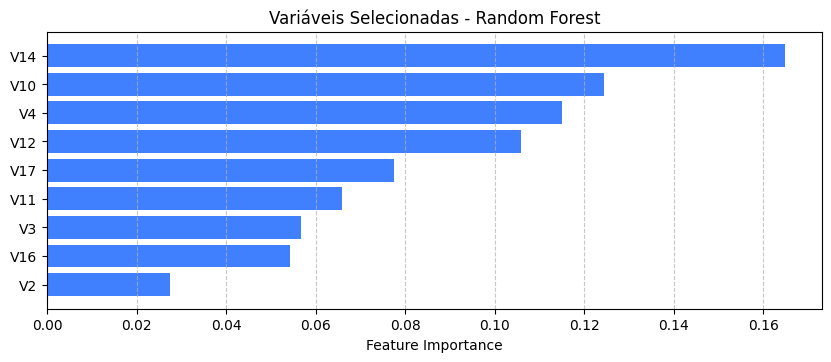

In [0]:
# Treina RF apenas para ranking de features

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_corr, y_train)

#Encontrando as variaveis mais importantes
import matplotlib.pyplot as plt


feature_importances = rf.feature_importances_

#Criando um dataframe com as features e a sua importância
feature = pd.DataFrame({
    'feature': X_corr.columns,
    'importance': feature_importances})

#Ordenando as variaveis por sua importância
feature.sort_values(by='importance', ascending=False)

#Estabelecendo um limite de corte para as feature importances (30%)
cutoff_max = 0.15

cut_off = cutoff_max * feature_importances.max()

#Selecionando Variaveis acima do limite

selected_features = X_corr.columns[feature_importances > cut_off].tolist()

print(f'Numero de features importances selecionadas {len(selected_features)}')
print(f'Features selecionadas {selected_features}')

#Ordenando as variaveis selecionadas
features = feature.sort_values(by='importance', ascending=True)

#Filtrar o dataframe para apenas features acima da corte
selected_features_df = features[features['importance'] > cut_off]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['feature'], selected_features_df['importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [0]:
with open('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/artefacts/cred_list_feature.pkl','wb') as pk:
    pickle.dump(selected_features,pk)

### 7.3 Aplicar seleção no Train / Cal / Test


In [0]:
X_train_fs = X_train_imp[selected_features]
X_cal_fs   = X_cal_imp[selected_features]
X_test_fs  = X_test_imp[selected_features]


## 8) Modelo base (XGBoost)
Parâmetros conservadores orientados a **precision**.


In [0]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight = min(ratio, 100)

xgb_prec = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    n_estimators=800,
    learning_rate=0.03,
    max_depth=2,
    min_child_weight=20,
    gamma=0.4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10.0,
    reg_alpha=0.2,
    scale_pos_weight=scale_pos_weight
)

xgb_prec.fit(X_train_fs, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=0.4, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=20, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=-1, num_parallel_tree=None, ...)

In [0]:
with open('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/artefacts/model_xgb.pkl','wb') as pk:
    pickle.dump(xgb_prec,pk)

## 9) Calibração + Threshold (somente no CAL)



In [0]:
calibrated = CalibratedClassifierCV(estimator=xgb_prec, method="sigmoid", cv="prefit")
calibrated.fit(X_cal_fs, y_cal)

proba_cal = calibrated.predict_proba(X_cal_fs)[:, 1]
prec, rec, thr = precision_recall_curve(y_cal, proba_cal)

target_precision = 0.40  
valid = np.where(prec[:-1] >= target_precision)[0]

if len(valid) == 0:
    best_thr = 0.99
else:
    best_idx = valid[np.argmax(rec[valid])]
    best_thr = float(thr[best_idx])

print("Threshold escolhido no CAL:", best_thr)


Threshold escolhido no CAL: 0.009996680542826653


In [0]:
print(calibrated)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.7,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='aucpr',
                                               feature_types=None,
                                               feature_weights=None, gamma=0.4,
                                               grow_policy=None,
                                               importance_type=None,
                                               interacti

In [0]:
with open('/Volumes/workspace/default/fraudes_em_cartões_de_crédito/artefacts/model_calibrated.pkl','wb') as pk:
    pickle.dump(calibrated,pk)

#  Avaliação (Holdout)
O conjunto `TEST`  é usado **uma única vez** aqui, para reportar o resultado final.


In [0]:
proba_test = calibrated.predict_proba(X_test_fs)[:, 1]
y_pred = (proba_test >= best_thr).astype(int)

print("Precision (TEST):", precision_score(y_test, y_pred, zero_division=0))
print("Recall (TEST):   ", recall_score(y_test, y_pred, zero_division=0))
print("ROC-AUC (TEST):  ", roc_auc_score(y_test, proba_test))
print("PR-AUC (TEST):   ", average_precision_score(y_test, proba_test))
print("KS (TEST):       ", calcular_ks_statistic(y_test, proba_test))
print("CM (TEST):\n", confusion_matrix(y_test, y_pred))

resultados = avaliar_modelo(X_train_fs, y_train, X_test_fs, y_test, calibrated, nm_modelo="XGBoost Calibrado (leakage-safe)")
resultados


Precision (TEST): 0.3423913043478261
Recall (TEST):    0.8513513513513513
ROC-AUC (TEST):   0.9642946261226935
PR-AUC (TEST):    0.6860255979582821
KS (TEST):        0.8564661912630727
CM (TEST):
 [[85053   242]
 [   22   126]]


{'modelo': 'XGBoost Calibrado (leakage-safe)',
 'roc_auc_train': 0.9996764372698952,
 'roc_auc_test': 0.9642946261226935,
 'gini_train': 0.9993528745397904,
 'gini_test': 0.9285892522453869,
 'ks_train': 0.9954087528891569,
 'ks_test': 0.8564661912630727,
 'pr_auc_train': 0.8334126700010875,
 'pr_auc_test': 0.6860255979582821}